## 1. Baseline MLP on Cora (Ignoring Graph Structure)

- Use only the **node features `X`** to predict the node labels.
- **Ignore the graph structure** entirely (we do not use the adjacency matrix `A`).

This baseline will give us a reference performance to compare against more advanced **Graph Neural Network (GNN)** models later.

### Why an MLP baseline?

- It treats each node **independently**, as if we shuffled and removed all edges.
- It can only learn from each node's own feature vector, **not from its neighbors**.
- Performance is usually **worse than GNNs**, because citation relationships (graph structure) are very informative for classification.

## 2. Load Preprocessed Cora Data from Disk

We previously saved the Cora dataset to the `../data/` directory in another notebook. Here, we will:

- Load the saved NumPy arrays for:
  - Node features `X.npy`
  - Labels `y.npy`
  - Adjacency matrix `A.npz` (loaded for completeness, but **not used** by the MLP)
  - Train / validation / test masks
- Confirm their shapes.

> **Important:** We do **not** call Spektral's dataset loader here. All data comes from the saved files.


In [47]:
# 2.1 Imports and data loading from ../data/

import os

import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Build path to ../data/ relative to this notebook
DATA_DIR = "../data"

X_path = os.path.join(DATA_DIR, "X.npy")
y_path = os.path.join(DATA_DIR, "y.npy")
A_path = os.path.join(DATA_DIR, "A.npz")
train_mask_path = os.path.join(DATA_DIR, "train_mask.npy")
val_mask_path = os.path.join(DATA_DIR, "val_mask.npy")
test_mask_path = os.path.join(DATA_DIR, "test_mask.npy")

# Load arrays
X = np.load(X_path)
y = np.load(y_path)
A = sp.load_npz(A_path)        
train_mask = np.load(train_mask_path)
val_mask = np.load(val_mask_path)
test_mask = np.load(test_mask_path)

print("Loaded data from disk:\n")
print(f"X shape:          {X.shape}")
print(f"y shape:          {y.shape}")
print(f"A shape:          {A.shape} (sparse)")
print(f"Train mask sum:   {train_mask.sum()}")
print(f"Val mask sum:     {val_mask.sum()}")
print(f"Test mask sum:    {test_mask.sum()}")

Loaded data from disk:

X shape:          (2708, 1433)
y shape:          (2708, 7)
A shape:          (2708, 2708) (sparse)
Train mask sum:   140
Val mask sum:     500
Test mask sum:    1000


## 3. Prepare Data for the MLP

The MLP expects:

- **Input**: dense feature vectors `X` with shape \((N, F)\), where:
  - \(N\) is the number of nodes.
  - \(F\) is the number of features per node.
- **Target labels**: one-hot encoded vectors `y` with shape \((N, C)\), where:
  - \(C\) is the number of classes.

We will use the boolean masks to split the data:

- `train_mask` for training.
- `val_mask` for validation.
- `test_mask` for final evaluation.

Each mask selects a subset of rows from `X` and `y`.

In [48]:
# 3.1 Apply masks to create train/val/test splits

X_train = X[train_mask]
y_train = y[train_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_test = X[test_mask]
y_test = y[test_mask]

num_nodes, num_features = X.shape
num_classes = y.shape[1]

print("Data splits:")
print(f"  Train: {X_train.shape[0]} nodes")
print(f"  Val:   {X_val.shape[0]} nodes")
print(f"  Test:  {X_test.shape[0]} nodes")
print(f"  Num features: {num_features}")
print(f"  Num classes:  {num_classes}")

Data splits:
  Train: 140 nodes
  Val:   500 nodes
  Test:  1000 nodes
  Num features: 1433
  Num classes:  7


### Enc / Dec / Gt / L (MLP Baseline)
- **Encoder:** MLP mapping node features X → latent embeddings Z.
- **Ground Truth (Gt):** the verified, "correct" labels used to train the model and evaluate its performance.
- **Decoder:** Softmax layer mapping Z → predicted class probabilities.
- **Loss (L):** Categorical cross-entropy comparing predictions to ground truth Y.


## 4. Define the MLP Model (No Graph Information)

We now define a simple **feed-forward neural network** (MLP):

- 1–2 hidden `Dense` layers with ReLU activation.
- An output `Dense` layer with softmax over the `num_classes`.

The model:

- Takes only `X` as input.
- Does **not** use the adjacency matrix `A`.
- Is trained with **categorical cross-entropy** loss, **Adam** optimizer, and **accuracy** as a metric.

In [49]:
num_features = X_train.shape[1]
num_classes = y_train.shape[1]
LR = 0.001
DROPOUT = 0.5
num_layers = 2
hidden_dimensions = [64,32]

model = keras.Sequential([
    layers.Input(shape=(num_features,)),
    
    layers.Dense(hidden_dimensions[0], activation="relu"),
    layers.Dropout(DROPOUT),
    
    layers.Dense(hidden_dimensions[1], activation="relu"),
    layers.Dropout(DROPOUT),
    
    layers.Dense(num_classes, activation="softmax"),
])
# ------------------UNDERFITTING----------------------------------------------------
# model = keras.Sequential([
#     layers.Input(shape=(num_features,)),
    
#     # Smaller, stabilized first layer
#     layers.Dense(64),
#     layers.BatchNormalization(),
#     layers.Activation("relu"),
#     layers.Dropout(0.5),
    
#     # Compact second layer
#     layers.Dense(32),
#     layers.BatchNormalization(),
#     layers.Activation("relu"),
#     layers.Dropout(0.5),
    
#     layers.Dense(num_classes, activation="softmax"),
# ])
# -----------------------------OVERFITTING-----------------------------------------
# model = keras.Sequential([
#     layers.Input(shape=(num_features,)),
    
#     # Smaller, stabilized first layer
#     layers.Dense(128, activation="relu"),
#     layers.Dropout(0.2),
#     layers.Dense(64, activation="relu"),
#     layers.Dense(num_classes, activation="softmax")
        
# ])
# --------------------------1 layer -------------------------------------
# model = keras.Sequential([
#     layers.Input(shape=(num_features,)),
    
#     layers.Dense(hidden_dimensions[0], activation="relu"),
#     layers.Dropout(DROPOUT),
    
#     layers.Dense(num_classes, activation="softmax"),
# ])
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │        91,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,087 (367.53 KB)

 Trainable params: 94,087 (367.53 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train the MLP and Monitor Performance

We will train the model using:

- **Training set**: nodes selected by `train_mask`.
- **Validation set**: nodes selected by `val_mask`.

Configuration:

- Loss: **categorical cross-entropy**.
- Optimizer: **Adam**.
- Metric: **accuracy**.
- A small number of epochs (e.g. 100) with **early stopping** on validation loss to avoid overfitting and unnecessary training time.

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1500 - loss: 1.9578 - val_accuracy: 0.1220 - val_loss: 1.9629
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.1429 - loss: 1.9607 - val_accuracy: 0.1240 - val_loss: 1.9606
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1143 - loss: 1.9373 - val_accuracy: 0.1280 - val_loss: 1.9578
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.1714 - loss: 1.9144 - val_accuracy: 0.1340 - val_loss: 1.9550
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1643 - loss: 1.9108 - val_accuracy: 0.1440 - val_loss: 1.9522
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2143 - loss: 1.8893 - val_accuracy: 0.1480 - val_loss: 1.9494
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2714 - loss: 1.8800 - val_accuracy: 0.1560 - val_loss: 1.9465
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2357 - loss: 1.8756 - val_accuracy: 0.1600 - val_loss: 1

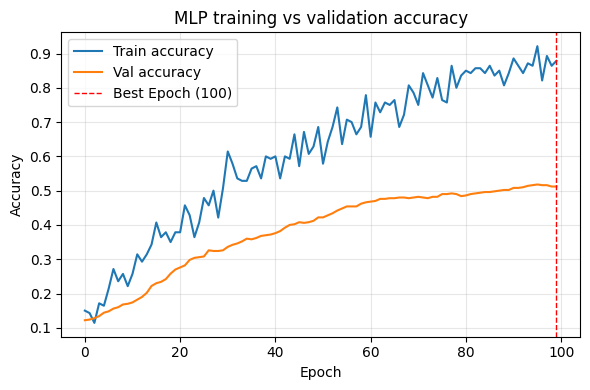

In [50]:
# 5. Train the model with early stopping
from datetime import datetime
batch_size = 256
epochs = 100
DATASET_NAME = "cora"
MODEL_NAME = "mlp"
PLOTS_DIR = os.path.join("..", "results", "plots", MODEL_NAME)
os.makedirs(PLOTS_DIR, exist_ok=True)
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
        verbose=1,
    )
]

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    callbacks=callbacks,
)
# Best epoch (0-based → +1 for humans)
best_epoch = np.argmin(history.history["val_loss"]) + 1

# Optional: visualize training and validation accuracy
plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], label="Train accuracy")
plt.plot(history.history["val_accuracy"], label="Val accuracy")
# Best epoch vertical line
plt.axvline(
    x=best_epoch - 1,
    color="red",
    linestyle="--",
    linewidth=1,
    label=f"Best Epoch ({best_epoch})"
)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP training vs validation accuracy")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
filename = (
    f"{MODEL_NAME}"
    f"_layer{num_layers}_dim{hidden_dimensions}"
    f"_bestEp{best_epoch}"
    f"_{timestamp}.png"
)

plt.savefig(
    os.path.join(PLOTS_DIR, filename),
    dpi=300,
    bbox_inches="tight"
)
plt.show()
plt.close()

## 6. Evaluate on Train, Validation, and Test Sets

We now evaluate the trained MLP on:

- The **training set** (to see how well it fits the training data).
- The **validation set** (used during training for early stopping).
- The **test set** (held-out data for final performance).

We will print the final accuracies clearly.

In [51]:
# 6.1 Compute final metrics on train / val / test

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Predict class probabilities
y_train_pred = model.predict(X_train, verbose=0)
y_val_pred   = model.predict(X_val, verbose=0)
y_test_pred  = model.predict(X_test, verbose=0)

# Convert probabilities → class labels
y_train_pred_cls = np.argmax(y_train_pred, axis=1)
y_val_pred_cls   = np.argmax(y_val_pred, axis=1)
y_test_pred_cls  = np.argmax(y_test_pred, axis=1)

y_train_true = np.argmax(y_train, axis=1)
y_val_true   = np.argmax(y_val, axis=1)
y_test_true  = np.argmax(y_test, axis=1)

# Accuracy
train_acc = accuracy_score(y_train_true, y_train_pred_cls)
val_acc   = accuracy_score(y_val_true, y_val_pred_cls)
test_acc  = accuracy_score(y_test_true, y_test_pred_cls)

# Precision, Recall, F1 (macro = equal weight per class)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    y_test_true,
    y_test_pred_cls,
    average="macro"
)

print("Final evaluation metrics (MLP baseline):\n")
print(f"Train accuracy:      {train_acc:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")
print(f"Test accuracy:       {test_acc:.4f}\n")

print(f"Test precision (macro): {test_precision:.4f}")
print(f"Test recall (macro):    {test_recall:.4f}")
print(f"Test F1-score (macro):  {test_f1:.4f}")


Final evaluation metrics (MLP baseline):

Train accuracy:      1.0000
Validation accuracy: 0.5120
Test accuracy:       0.5230

Test precision (macro): 0.5225
Test recall (macro):    0.5521
Test F1-score (macro):  0.5107


## 7. Save Test Accuracy to `results/metrics.csv`

To keep track of different experiments, we save the **test accuracy** of this MLP baseline to `results/metrics.csv`.

The CSV file will contain at least the following columns:

- `model`: name/description of the model.
- `dataset`: which dataset was used (here always `cora`).
- `test_accuracy`: final test accuracy.

We will **append** a new row if the file already exists; otherwise, we will create it with a header.

In [52]:
# 7.1 Save metrics to results/metrics.csv

import csv
import os

RESULTS_DIR = "../results"
os.makedirs(RESULTS_DIR, exist_ok=True)

metrics_path = os.path.join(RESULTS_DIR, "metrics.csv")
file_exists = os.path.isfile(metrics_path)

fieldnames = [
    "model",
    "dataset",
    "test_accuracy",
    "test_precision_macro",
    "test_recall_macro",
    "test_f1_macro",
]

row = {
    "model": "mlp_baseline",
    "dataset": "cora",
    "test_accuracy": f"{test_acc:.4f}",
    "test_precision_macro": f"{test_precision:.4f}",
    "test_recall_macro": f"{test_recall:.4f}",
    "test_f1_macro": f"{test_f1:.4f}",
}

with open(metrics_path, mode="a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not file_exists:
        writer.writeheader()
    writer.writerow(row)

print(f"✅ Saved MLP metrics to {metrics_path}")


✅ Saved MLP metrics to ../results/metrics.csv
